
==== 3D-MEDIUM SYMMETRY REPORT ====
corr_len_z_steps = 1   (a = 0.367879)
ε_sym (reference)        = 1.687e-14
⟨ε_sym⟩ (single-shot)    = 0.444  (std=0.102)
ε_sym (ensemble mean)     = 6.612e-02
⟨δn⟩ over realizations    = -8.410e-25
π-rotation bias of δn     = 2.220e-06

==== 3D-MEDIUM SYMMETRY REPORT ====
corr_len_z_steps = 2   (a = 0.606531)
ε_sym (reference)        = 1.687e-14
⟨ε_sym⟩ (single-shot)    = 0.596  (std=0.133)
ε_sym (ensemble mean)     = 9.243e-02
⟨δn⟩ over realizations    = -3.412e-24
π-rotation bias of δn     = 2.218e-06

==== 3D-MEDIUM SYMMETRY REPORT ====
corr_len_z_steps = 5   (a = 0.818731)
ε_sym (reference)        = 1.687e-14
⟨ε_sym⟩ (single-shot)    = 0.868  (std=0.175)
ε_sym (ensemble mean)     = 1.478e-01
⟨δn⟩ over realizations    = 3.391e-24
π-rotation bias of δn     = 2.229e-06

==== 3D-MEDIUM SYMMETRY REPORT ====
corr_len_z_steps = 10   (a = 0.904837)
ε_sym (reference)        = 1.687e-14
⟨ε_sym⟩ (single-shot)    = 1.079  (std=0.177)
ε_sym (ensemble mean)  

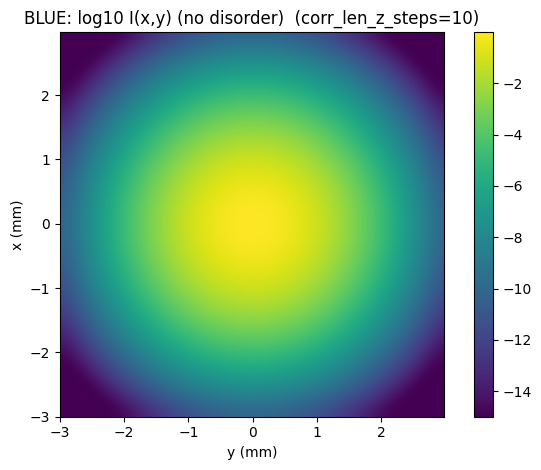

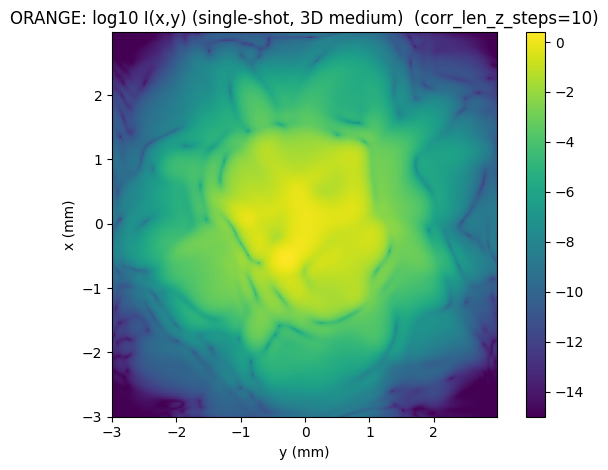

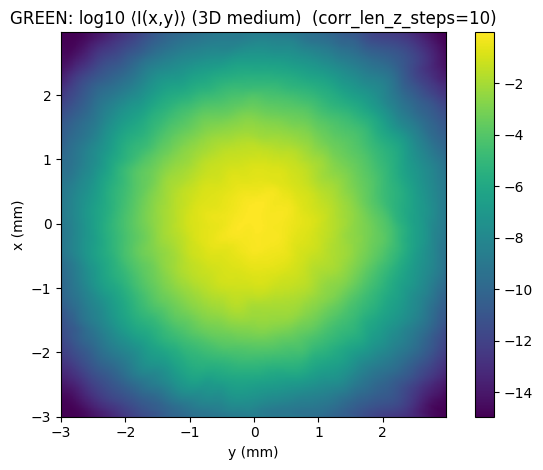

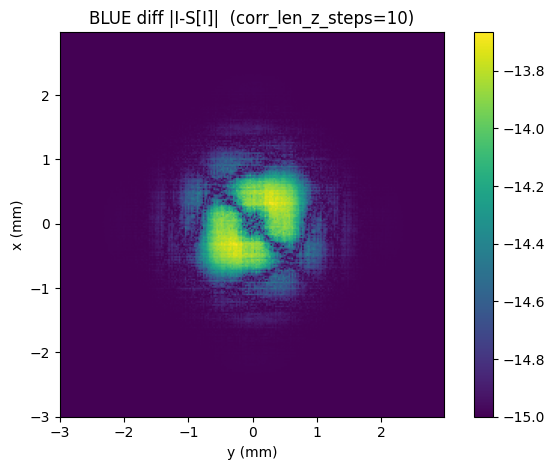

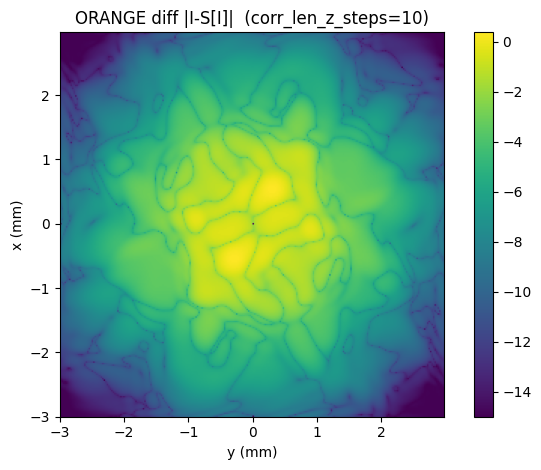

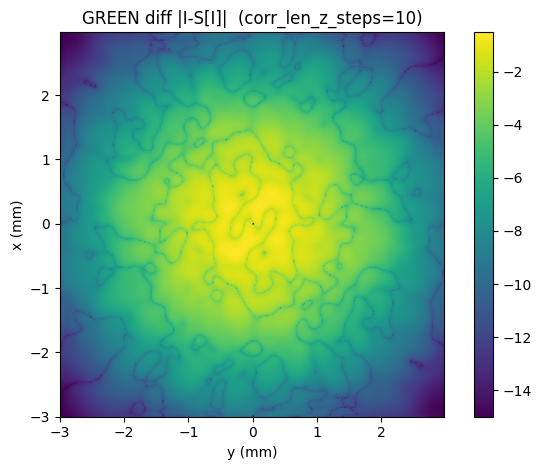

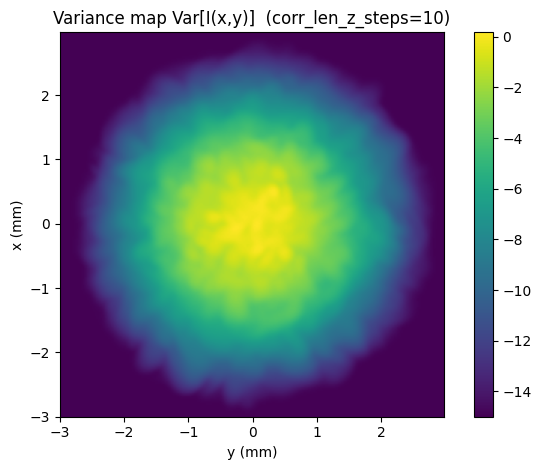


==== 3D-MEDIUM SYMMETRY REPORT ====
corr_len_z_steps = 20   (a = 0.951229)
ε_sym (reference)        = 1.687e-14
⟨ε_sym⟩ (single-shot)    = 1.239  (std=0.154)
ε_sym (ensemble mean)     = 2.520e-01
⟨δn⟩ over realizations    = 5.239e-24
π-rotation bias of δn     = 2.225e-06

==== 3D-MEDIUM SYMMETRY REPORT ====
corr_len_z_steps = 50   (a = 0.980199)
ε_sym (reference)        = 1.687e-14
⟨ε_sym⟩ (single-shot)    = 1.358  (std=0.138)
ε_sym (ensemble mean)     = 2.933e-01
⟨δn⟩ over realizations    = -6.535e-24
π-rotation bias of δn     = 2.232e-06

==== 3D-MEDIUM SYMMETRY REPORT ====
corr_len_z_steps = 100   (a = 0.990050)
ε_sym (reference)        = 1.687e-14
⟨ε_sym⟩ (single-shot)    = 1.386  (std=0.138)
ε_sym (ensemble mean)     = 3.002e-01
⟨δn⟩ over realizations    = -1.488e-23
π-rotation bias of δn     = 2.227e-06


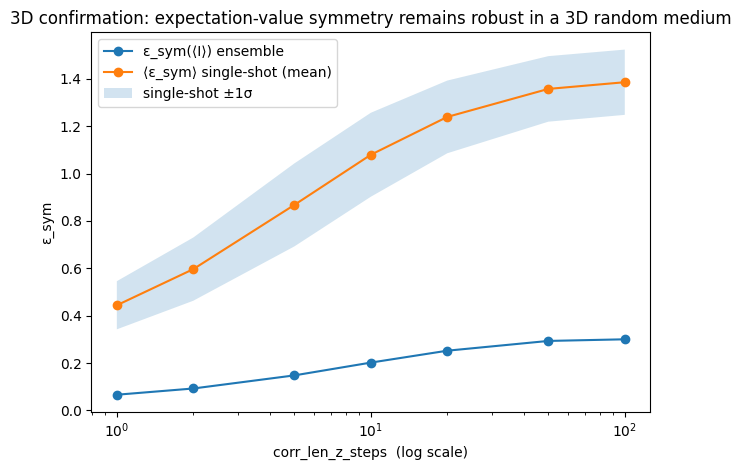

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Core numerics: beam, disorder, propagation
# ============================================================

def gaussian_beam_2d(X, Y, w0=0.6e-3):
    """Real-valued Gaussian envelope (symmetric)."""
    return np.exp(-(X**2 + Y**2) / (2*w0**2))

def correlated_noise_2d(nx, ny, dx, corr_len_xy, rng):
    """Zero-mean, unit-std correlated Gaussian random field in 2D using spectral filtering."""
    kx = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=dx)
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2

    w = rng.normal(size=(nx, ny)) + 1j*rng.normal(size=(nx, ny))
    filt = np.exp(-0.5 * K2 * (corr_len_xy**2))

    noise = np.fft.ifft2(w * filt).real
    noise -= noise.mean()
    noise /= (noise.std() + 1e-15)
    return noise

def precompute_diffraction_operator(nx, ny, dx, dz, k0):
    """Precompute diffraction operator exp(-i (kx^2+ky^2) dz / (2k0))."""
    kx = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=dx)
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2
    return np.exp(-1j * K2 * dz / (2*k0))

def one_split_step(E, expD, V, dz):
    """One split-step update with potential V(x,y) = k0*delta_n(x,y)."""
    expV = np.exp(-1j * V * dz / 2)
    E = expV * E
    Ek = np.fft.fft2(E)
    Ek *= expD
    E = np.fft.ifft2(Ek)
    E = expV * E
    return E

# ============================================================
# Correct discrete symmetry operator (pi rotation)
# ============================================================

def pi_rotate_discrete(I):
    """
    Correct discrete implementation of (x,y)->(-x,-y) for even grids.
    """
    J = I[::-1, ::-1]
    if I.shape[0] % 2 == 0:
        J = np.roll(J, 1, axis=0)
    if I.shape[1] % 2 == 0:
        J = np.roll(J, 1, axis=1)
    return J

def eps_sym_pi(I):
    J = pi_rotate_discrete(I)
    return np.sum(np.abs(I - J)) / (np.sum(I) + 1e-15)

def diff_map_pi(I):
    return np.abs(I - pi_rotate_discrete(I))

# ============================================================
# 3D medium model: z-dependent disorder via OU/AR(1) in z
# ============================================================

def run_2d_in_3d_medium(
    seed=7,
    Nreal=60,
    lam=800e-9,
    L=6e-3,
    N=256,
    z_total=0.4,
    dz=2e-3,
    corr_len_xy=0.25e-3,
    sigma_dn=2e-6,
    corr_len_z_steps=10.0,   # correlation length along z measured in steps
    w0=0.6e-3,
    do_plots=False,
    plot_title_suffix=""
):
    """
    Propagate a 2D beam through a genuinely 3D random medium delta_n(x,y,z).
    delta_n is generated as an AR(1) process in z:
        dn_{m+1} = a dn_m + sqrt(1-a^2) eta_m
    where eta_m is a fresh correlated 2D field (xy correlation set by corr_len_xy).
    """

    rng = np.random.default_rng(seed)
    k0 = 2*np.pi/lam
    nsteps = int(np.round(z_total / dz))

    x = np.linspace(-L/2, L/2, N, endpoint=False)
    dx = x[1] - x[0]
    X, Y = np.meshgrid(x, x, indexing='ij')

    # symmetric initial field
    E0 = gaussian_beam_2d(X, Y, w0=w0).astype(np.complex128)

    # diffraction operator (constant)
    expD = precompute_diffraction_operator(N, N, dx, dz, k0)

    # ---- BLUE reference (no disorder) ----
    E_ref = E0.copy()
    V0 = np.zeros((N, N), dtype=float)
    for _ in range(nsteps):
        E_ref = one_split_step(E_ref, expD, V0, dz)
    I_ref = np.abs(E_ref)**2
    eps_ref = eps_sym_pi(I_ref)

    # ---- z-correlation parameter a ----
    # corr_len_z_steps -> larger means slower changes in z
    corr_len_z_steps = max(float(corr_len_z_steps), 1e-9)
    a = np.exp(-1.0 / corr_len_z_steps)   # in (0,1)

    # ---- ensemble ----
    I_all = np.zeros((Nreal, N, N), dtype=np.float64)
    eps_single = np.zeros(Nreal, dtype=np.float64)

    # track disorder sanity
    mean_dn_across_reals = []
    parity_bias_dn = []

    for r in range(Nreal):
        E = E0.copy()

        # OU/AR(1) state in z
        dn_state = np.zeros((N, N), dtype=float)

        for _ in range(nsteps):
            eta = correlated_noise_2d(N, N, dx, corr_len_xy, rng)
            dn_state = a * dn_state + np.sqrt(max(1.0 - a*a, 0.0)) * eta
            delta_n = sigma_dn * dn_state
            V = k0 * delta_n
            E = one_split_step(E, expD, V, dz)

        I = np.abs(E)**2
        I_all[r] = I
        eps_single[r] = eps_sym_pi(I)

        mean_dn_across_reals.append(delta_n.mean())
        parity_bias_dn.append(np.mean(np.abs(delta_n - pi_rotate_discrete(delta_n))))

    I_mean = I_all.mean(axis=0)
    eps_ens = eps_sym_pi(I_mean)
    I_var = I_all.var(axis=0)

    report = {
        "eps_ref": eps_ref,
        "eps_single": eps_single,
        "eps_single_mean": float(eps_single.mean()),
        "eps_single_std": float(eps_single.std()),
        "eps_ens": eps_ens,
        "mean_dn": float(np.mean(mean_dn_across_reals)),
        "parity_bias_dn": float(np.mean(parity_bias_dn)),
        "x": x,
        "I_ref": I_ref,
        "I_one": I_all[len(I_all)//2],
        "I_mean": I_mean,
        "I_var": I_var,
    }

    print("\n==== 3D-MEDIUM SYMMETRY REPORT ====")
    print(f"corr_len_z_steps = {corr_len_z_steps:.3g}   (a = {a:.6f})")
    print(f"ε_sym (reference)        = {eps_ref:.3e}")
    print(f"⟨ε_sym⟩ (single-shot)    = {report['eps_single_mean']:.3f}  (std={report['eps_single_std']:.3f})")
    print(f"ε_sym (ensemble mean)     = {eps_ens:.3e}")
    print(f"⟨δn⟩ over realizations    = {report['mean_dn']:.3e}")
    print(f"π-rotation bias of δn     = {report['parity_bias_dn']:.3e}")

    if do_plots:
        extent = [x[0]*1e3, x[-1]*1e3, x[0]*1e3, x[-1]*1e3]

        def show(field, title, log=True, vmin=None, vmax=None):
            plt.figure()
            data = np.log10(field + 1e-15) if log else field
            plt.imshow(data, origin="lower", extent=extent, vmin=vmin, vmax=vmax)
            plt.xlabel("y (mm)")
            plt.ylabel("x (mm)")
            plt.title(title + plot_title_suffix)
            plt.colorbar()
            plt.tight_layout()

        show(report["I_ref"],  "BLUE: log10 I(x,y) (no disorder)")
        show(report["I_one"],  "ORANGE: log10 I(x,y) (single-shot, 3D medium)")
        show(report["I_mean"], "GREEN: log10 ⟨I(x,y)⟩ (3D medium)")

        show(diff_map_pi(report["I_ref"]),  "BLUE diff |I-S[I]|", log=True)
        show(diff_map_pi(report["I_one"]),  "ORANGE diff |I-S[I]|", log=True)
        show(diff_map_pi(report["I_mean"]), "GREEN diff |I-S[I]|", log=True)

        show(report["I_var"], "Variance map Var[I(x,y)]", log=True)
        plt.show()

    return report

# ============================================================
# Figure requested: robustness vs corr_len_z
# ============================================================

def figure_3d_confirmation_corrlenz(
    corr_len_z_steps_list,
    seed=7,
    Nreal=60,
    sigma_dn=2e-6,
    show_example_maps_at=None  # e.g. 10 or 1 or 100
):
    """
    Generates the key 3D confirmation plot:
        y-axis: epsilon_sym(ensemble)
        x-axis: corr_len_z_steps
    plus microstate mean (single-shot mean) on same axes.
    """

    ens_vals = []
    single_vals = []
    single_err = []

    for clz in corr_len_z_steps_list:
        out = run_2d_in_3d_medium(
            seed=seed,
            Nreal=Nreal,
            sigma_dn=sigma_dn,
            corr_len_z_steps=clz,
            do_plots=(show_example_maps_at is not None and float(clz) == float(show_example_maps_at)),
            plot_title_suffix=f"  (corr_len_z_steps={clz})"
        )
        ens_vals.append(out["eps_ens"])
        single_vals.append(out["eps_single_mean"])
        single_err.append(out["eps_single_std"])

    ens_vals = np.array(ens_vals)
    single_vals = np.array(single_vals)
    single_err = np.array(single_err)

    # --- main plot ---
    plt.figure()
    plt.plot(corr_len_z_steps_list, ens_vals, marker="o", label="ε_sym(⟨I⟩) ensemble")
    plt.plot(corr_len_z_steps_list, single_vals, marker="o", label="⟨ε_sym⟩ single-shot (mean)")
    plt.fill_between(
        corr_len_z_steps_list,
        single_vals - single_err,
        single_vals + single_err,
        alpha=0.2,
        label="single-shot ±1σ"
    )

    plt.xscale("log")
    plt.xlabel("corr_len_z_steps  (log scale)")
    plt.ylabel("ε_sym")
    plt.title("3D confirmation: expectation-value symmetry remains robust in a 3D random medium")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================
# Main entry
# ============================================================

if __name__ == "__main__":
    # Recommended sweep range:
    # small -> rapidly varying disorder in z
    # large -> almost z-invariant (reduces toward your old 2D-slice model)
    corr_list = [1, 2, 5, 10, 20, 50, 100]

    # Make the main 3D confirmation figure.
    # Set show_example_maps_at=10 to also generate contour maps for corr_len_z_steps=10.
    figure_3d_confirmation_corrlenz(
        corr_len_z_steps_list=corr_list,
        seed=7,
        Nreal=60,
        sigma_dn=2e-6,
        show_example_maps_at=10
    )

